#Import

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Model
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, MaxPool2D,Conv2DTranspose, concatenate,Input,Activation,MaxPooling2D

# Load data

In [4]:
# Paths to our images and masks folders
imgs_dir = '/content/drive/MyDrive/CS331/Unet/data/data/images/'
masks_dir = '/content/drive/MyDrive/CS331/Unet/data/data/masks/'

In [5]:
img_f = sorted(os.listdir(imgs_dir))
mask_f = sorted(os.listdir(masks_dir))
imgs_arr = np.zeros((len(os.listdir(imgs_dir)), 256, 256, 3), dtype = np.float32)
masks_arr = np.zeros((len(os.listdir(masks_dir)), 256, 256, 1), dtype = np.float32)



for index in range(len(os.listdir(imgs_dir))):
    img = load_img(os.path.join(imgs_dir, img_f[index]), target_size = (256, 256, 3))
    imgs_arr[index] = img_to_array(img)
    


for index in range(len(os.listdir(masks_dir))):
    img = load_img(os.path.join(masks_dir, mask_f[index]), target_size = (256, 256, 1), color_mode="grayscale" )
    masks_arr[index] = img_to_array(img)


imgs_arr /= 255.
masks_arr /= 255.

x_train = imgs_arr[10:]
y_train = masks_arr[10:]

x_test = imgs_arr[0:10]
y_test = masks_arr[0:10]

In [ ]:
masks_arr.shape

(1192, 256, 256, 1)

In [6]:
# biến thành dim 3
def convert_mask(m):
  pred_ = m
  pred_ = np.concatenate(
        [
        pred_ , pred_ , pred_

        ], axis = 2
    )
  return pred_

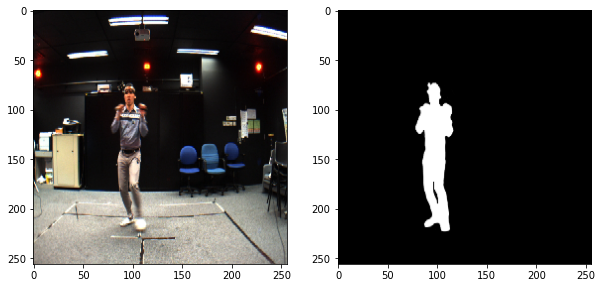

In [7]:
# Vd
import matplotlib.pyplot as plt
f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(imgs_arr[0])
f.add_subplot(1,2, 2)
plt.imshow(convert_mask(masks_arr[0]))
plt.show(block=True)

# Build Unet

In [8]:
def conv_block(input, n_filters, kernel_size=3, padding='same', activation='relu'):
    x = Conv2D(n_filters, kernel_size, padding=padding)(input)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(n_filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

In [9]:
def encoder_block(input, n_filters, kernel_size=3, padding='same', activation='relu'):
    x = conv_block(input, n_filters, kernel_size, padding, activation)
    p = MaxPooling2D((2, 2), padding='same')(x)
    return x , p

In [10]:
def encoder_block(input, n_filters, kernel_size=3, padding='same', activation='relu'):
    x = conv_block(input, n_filters, kernel_size, padding, activation)
    p = MaxPooling2D((2, 2), padding='same')(x)

    return x , p

In [11]:
def decoder_block(input, skip_input, n_filters, kernel_size=3, padding='same', activation='relu'):
    x = Conv2DTranspose(n_filters,(2,2),strides=2, padding='same')(input)
    x = concatenate([x, skip_input])
    x = conv_block(x, n_filters, kernel_size, padding, activation)
    return x

In [12]:
def build_unet(input_shape, n_filters=16, kernel_size=3, padding='same', activation='relu'):
    input = Input(input_shape)

    # Downsampling path
    e1, p1 = encoder_block(input, n_filters, kernel_size, padding, activation)
    e2, p2 = encoder_block(p1, n_filters*2, kernel_size, padding, activation)
    e3, p3 = encoder_block(p2, n_filters*4, kernel_size, padding, activation)
    e4, p4 = encoder_block(p3, n_filters*8, kernel_size, padding, activation)
    e5, p5 = encoder_block(p4, n_filters*16, kernel_size, padding, activation)
    e6, p6 = encoder_block(p5, n_filters*32, kernel_size, padding, activation)

    #Bridge
    b = conv_block(p6, n_filters*64, kernel_size, padding, activation)
     
    # Upsampling path
    d1 = decoder_block(b, e6, n_filters*32, kernel_size, padding, activation)
    d2 = decoder_block(d1, e5, n_filters*16, kernel_size, padding, activation)
    d3 = decoder_block(d2, e4, n_filters*8, kernel_size, padding, activation)
    d4 = decoder_block(d3, e3, n_filters*4, kernel_size, padding, activation)
    d5 = decoder_block(d4, e2, n_filters*2, kernel_size, padding, activation)
    d6 = decoder_block(d5, e1, n_filters, kernel_size, padding, activation)


    # Output
    outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(d6)
    model = Model(inputs=[input], outputs=[outputs], name='UNET')
    return model

In [18]:
model = build_unet((256, 256, 3))
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 256, 256, 16  64         ['conv2d_3[0][0]']               
 rmalization)                   )                                                              

# Train

In [19]:
from keras import backend as K
# Jaccard coeficient or IoU
def jaccard_coef(y_true,y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    return (intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)-intersection+smooth)
# Jaccard loss
def jaccard_loss(y_true,y_pred,smooth=1):
    # We are multiplying IoU with -1 because we are trying to maximize the IoU so it will get bigger every iteration
    return -jaccard_coef(y_true,y_pred,smooth)

In [20]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss=[jaccard_loss],metrics=[jaccard_coef])

In [21]:
history = model.fit(x_train,y_train,batch_size=32,epochs=25,validation_split=0.2)

Epoch 1/25
30/30 [==============================] - 36s 542ms/step - loss: -0.0936 - jaccard_coef: 0.0942 - val_loss: -0.0515 - val_jaccard_coef: 0.0510
Epoch 2/25
30/30 [==============================] - 11s 357ms/step - loss: -0.1390 - jaccard_coef: 0.1393 - val_loss: -0.0767 - val_jaccard_coef: 0.0755
Epoch 3/25
30/30 [==============================] - 11s 364ms/step - loss: -0.1773 - jaccard_coef: 0.1776 - val_loss: -0.0478 - val_jaccard_coef: 0.0473
Epoch 4/25
30/30 [==============================] - 11s 379ms/step - loss: -0.2310 - jaccard_coef: 0.2317 - val_loss: -0.0749 - val_jaccard_coef: 0.0742
Epoch 5/25
30/30 [==============================] - 11s 366ms/step - loss: -0.3120 - jaccard_coef: 0.3133 - val_loss: -0.1034 - val_jaccard_coef: 0.1020
Epoch 6/25
30/30 [==============================] - 11s 384ms/step - loss: -0.4206 - jaccard_coef: 0.4214 - val_loss: -0.3040 - val_jaccard_coef: 0.3029
Epoch 7/25
30/30 [==============================] - 11s 367ms/step - loss: -0.5454

# Eval

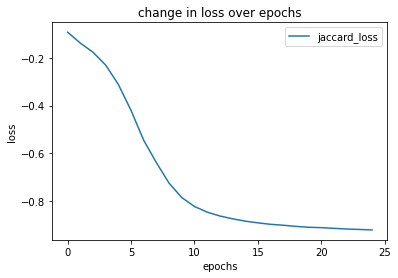

In [22]:
# Plotting loss change over epochs
x = [i for i in range(25)]
plt.plot(x,history.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['jaccard_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

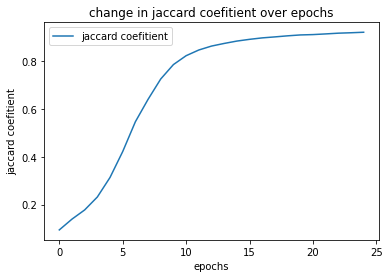

In [23]:
# Plotting IoU change over epochs, this will be same as loss just inverted so you can skip this part!
x = [i for i in range(25)]
plt.plot(x,history.history['jaccard_coef'])
plt.title('change in jaccard coefitient over epochs')
plt.legend(['jaccard coefitient'])
plt.xlabel('epochs')
plt.ylabel('jaccard coefitient')
plt.show()

# Test

In [24]:
predictions = model.predict(x_test)

In [25]:
def create_mask(predictions,input_shape=(256,256,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.9] = 1
    return mask

In [26]:
# Ploting results for one image
def plot_results_for_one_sample(sample_index):
    mask = create_mask(predictions[sample_index])
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(x_test[sample_index])
    f.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(convert_mask(y_test[sample_index]))
    f.add_subplot(1,4,3)
    plt.title('Predicted mask')
    plt.imshow(convert_mask(mask))
    f.add_subplot(1,4,4)
    plt.title("Mask + image")
    plt.imshow(x_test[sample_index]*mask)

In [27]:
import random
def plot():
  id = random.randint(0, 9)
  print(id)
  plot_results_for_one_sample(id)

5


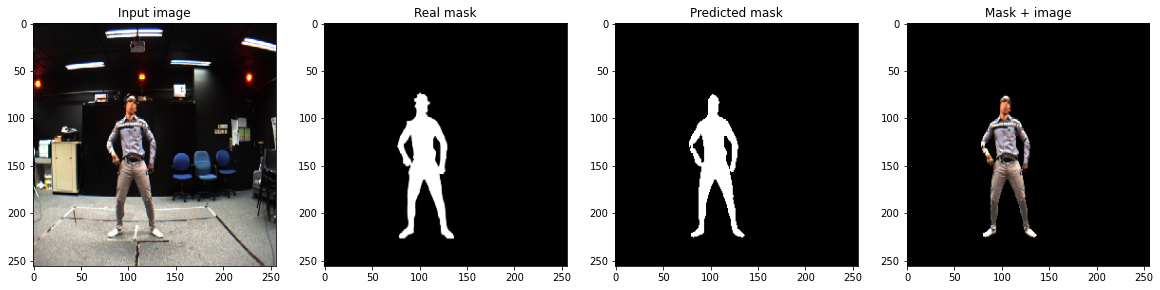

In [35]:
plot()